# 15wk-1: (강화학습) – LunarLander

최규빈  
2025-06-14

<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/15wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-wRrm_RgJ30iOUKf8q-S6hP&si=JJC7LNK2zUvB275J>

# 2. Imports

> **Note**
>
> *코랩사용자는 아래코드 실행후 실습할것 *
>
> ``` python
> !pip install swig
> !pip install gymnasium[box2d]
> ```
>
> *학과서버사용자는 가상환경에서 아래를 설치*
>
> ``` bash
> conda install conda-forge::gymnasium-box2d 
> ```

In [1]:
import gymnasium as gym
#--#
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import IPython
#--#
import collections
import random
#--#
import torch

In [2]:
def show(imgs,jump=10):
    imgs = imgs[::jump]
    fig = plt.Figure()
    ax = fig.subplots()
    def update(i):
        ax.imshow(imgs[i])
    ani = FuncAnimation(fig,update,frames=len(imgs))
    display(IPython.display.HTML(ani.to_jshtml()))

# 3. 예비학습

`-` `random.sample()`의 용법을 살펴보자.

`# 예시1`

In [3]:
random.sample([1,2,3,4,5],2)

`# 예시2`

In [4]:
s = [[0,0], [0,2], [3,2]]
a = [0,1,2]
memory = list(zip(s,a))
random.sample(memory,2)

# 4. env: LunarLander

`-` ref: <https://gymnasium.farama.org/environments/box2d/lunar_lander/>

`-` Lunar Lander: 요약

**Observation Space (State Space)** – 8개의 변수

1.  착륙선의 x 좌표
2.  착륙선의 y 좌표
3.  착륙선의 x 속도
4.  착륙선의 y 속도
5.  착륙선의 각도
6.  착륙선의 각속도
7.  왼쪽 다리가 땅에 닿아있는지 여부 (1 또는 0)
8.  오른쪽 다리가 땅에 닿아있는지 여부 (1 또는 0)

**Action Space** – 4개의 변수

1.  {0 : 아무 행동도 하지 않음}
2.  {1 : 왼쪽 엔진 발사 (오른쪽으로 기울임)}
3.  {2 : 메인 엔진 발사 (위로 밀어 올림)}
4.  {3 : 오른쪽 엔진 발사 (왼쪽으로 기울임)}

**Reward**

-   **거리 보상**: 착륙 패드에 가까울수록 보상 증가
-   **속도 보상**: 속도가 낮을수록 보상 증가
-   **각도 보상**: 각도가 수직에 가까울수록 보상 증가
-   **착륙 다리 보상**: 다리가 착륙 패드에 닿으면 보상
-   **연료 사용 패널티**: 엔진 사용 시 패널티
-   **안전한 착륙 보상**: 안정적으로 착륙 시 큰 보상 (+100~+140)
-   **충돌 패널티**: 착륙 패드 이외의 장소에 충돌 시 패널티 (-100)

`-` 환경생성

In [5]:
env = gym.make("LunarLander-v3", render_mode = "rgb_array")
env 

<frozen importlib._bootstrap>:228: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.

`-` state_space

In [6]:
env.observation_space.sample()

-   8개의 숫자가 포함된 array가 나옴
-   이 8개의 숫자는 각각 상태를 의미함

`-` action_space

In [7]:
env.action_space.sample()

-   0,1,2,3 중 하나가 랜덤으로 뽑힘

`-` env.reset()

In [8]:
env.reset()

`-` env.render()

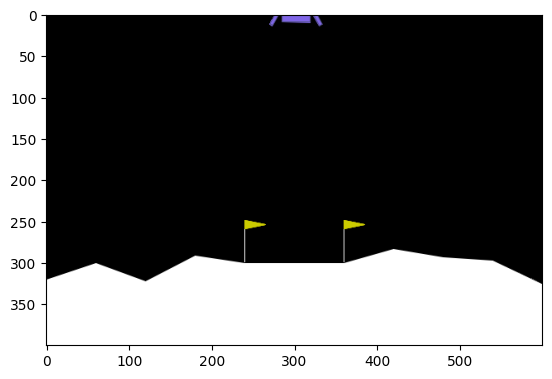

In [9]:
plt.imshow(env.render())

`-` env.step

In [10]:
env.step??

-   리턴되는 값은 `observation`, `reward`, `terminated`, `truncated`,
    `info`
-   우리가 쓰는 값은 `observation`, `reward`, `terminated`, `truncated`

`-` play

*첫시작화면*

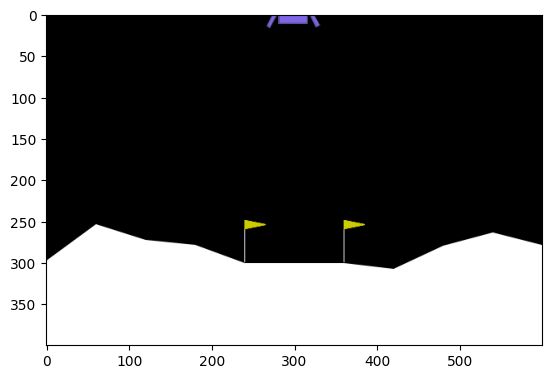

In [11]:
env.reset()
plt.imshow(env.render())

*플레이해보자*

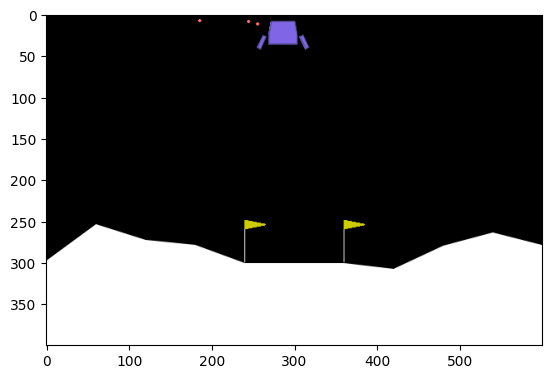

In [12]:
for _ in range(5):
    env.step(0) 
    env.step(3) 
plt.imshow(env.render())

# 5. 시각화

In [13]:
state, _ = env.reset()
imgs = []
for t in range(500):
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, _ = env.step(action)
    imgs.append(env.render())
    state = next_state 
    if terminated or truncated:
        break

In [14]:
show(imgs)

# 6. `RandomAgent`

In [15]:
class RandomAgent:
    def __init__(self):
        self.action_spcae = gym.spaces.Discrete(4)
        self.n_experieces = 0 
        #---#
        self.state = None 
        self.action = None 
        self.reward = None 
        self.next_state = None 
        self.terminated = None 
        #---#
        self.states = collections.deque(maxlen = 5000)
        self.actions = collections.deque(maxlen = 5000)
        self.rewards = collections.deque(maxlen = 5000)
        self.next_states = collections.deque(maxlen = 5000)
        self.terminations = collections.deque(maxlen = 5000)
    def act(self):
        self.action = self.action_spcae.sample()
    def learn(self):
        pass 
    def save_experience(self):
        self.states.append(torch.tensor(self.state))
        self.actions.append(self.action)
        self.rewards.append(self.reward)
        self.next_states.append(torch.tensor(self.next_state))
        self.terminations.append(self.terminated)
        self.n_experieces = self.n_experieces+1

In [16]:
env = gym.make("LunarLander-v3", render_mode = "rgb_array")
player = RandomAgent()
player.state,_ = env.reset()
for e in range(1,101):
    while True:
        # step1
        player.act()
        # step2
        player.next_state, player.reward, player.terminated, player.truncated, _ = env.step(player.action)
        # step3
        player.save_experience()
        player.learn()
        # step4 
        if player.terminated or player.truncated: 
            player.state, _ = env.reset()
            break 
        else: 
            player.state = player.next_state

# 7. `q_net`

In [17]:
# 이제 우리가 할것: q_table --> action 을 결정해야함. 

# 4x4 그리드 -- 복습 
# q_table[상태] = [행동0을했을때 품질, 행동1을했을때품질, 행동2를했을때품질, 행동3을했을때품질]  
# 행동 = argmax(q_talbe[상태])

# 루나랜더 -- 오늘 할것 
# q_net[8개의숫자] = [행동0을했을때 품질, 행동1을했을때품질, 행동2를했을때품질, 행동3을했을때품질] # 결국 숫자8개를 숫자4개로 만들어주는 적당한 q_net을 구성
# 행동 = argmax(q_net[8개의숫자])

`-` 전략: 4x4에서 `q_table`에 대응하는 뭔가가 있으면 된다. 그런데
`q_table`와 같이 테이블 형식으로는 힘들것 같다. $\to$ `q_net`를 만들자.

-   4x4 grid: 상태공간의 차원은 2차원이며 가질수 있는 값은 16개, 각
    상태공간에서 할수 있는 행동이 4개 -\> 총 16\*4의 경우의 수에 대한
    reward만 조사하면 되었음
-   LunarLander: 상태공간의 차원은 8차원이지만 가질수 있는 값의 범위는
    무한대 -\> 무수히 많은 경우에 대한 reward 값을 조사하는건 현실적으로
    불가능

*상황*

In [18]:
state = player.states[100]
action = player.actions[100]
reward = player.rewards[100]
next_state = player.next_states[100]
terminated = player.terminations[100]

`1`. `q_net`

In [19]:
player.q_net = torch.nn.Sequential(
    torch.nn.Linear(8,256),
    torch.nn.ReLU(),
    torch.nn.Linear(256,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,4)
)

In [20]:
player.q_net(state)

-   8개의 숫자가 들어가서 4개의 숫자가 나옴

`2`. `q_hat`

In [21]:
q_hat = player.q_net(state)[action]

`3`. `q` ($q = r + 0.99 \times {\tt future}$)

In [22]:
if terminated: 
    q = reward # q는 꼬리표가 없는 숫자 
else: 
    future = player.q_net(next_state).max().data # future에 꼬리표가 있으면 q에도 꼬리표가 생기므로 꼬리표 제거 
    q = reward + 0.99 * future # q는 꼬리표가 없는 숫자 

`4`. `q_hat` 을 점점 `q` 와 비슷하게 만드는 과정 = `player.q_net`를
학습하는 과정

In [23]:
# loss = (q_hat - q)**2
# loss를 점차 줄이면됨

In [24]:
player.optimizr = torch.optim.Adam(player.q_net.parameters())
for epoc in range(5):
    memory = list(zip(player.states, player.actions, player.rewards, player.next_states, player.terminations))
    mini_batch = random.sample(memory,64)
    # step1-2 
    loss = 0
    for s,a,r,ss,tmd in mini_batch:
        q_hat = player.q_net(s)[a]
        if tmd: 
            q = r 
        else: 
            future = player.q_net(ss).max().data 
            q = r + 0.99 * future
        loss = loss + (q_hat-q)**2
    loss = loss / 64
    # step3
    loss.backward()
    # step4 
    player.optimizr.step()
    player.optimizr.zero_grad()

`5`. 행동..?

In [25]:
# 이전에는 아래와 같은 방식
## 1. 특정 시점 이전에는 계속 랜덤액션만
## 2. 특정 시점 이후에는 계속 q_table에서 도출되는 행동만 
# 이번에는 아래와 같이 해보자. 
## 1. 처음에는 랜덤액션
## 2. 점차 에피소드가 지날수록, q_net에서 근거한 행동만

In [26]:
player.eps = 0.5 
if random.random() < player.eps: 
    player.action = player.action_spcae.sample()
else:
    state = torch.tensor(player.state)
    player.action = player.q_net(state).argmax().item()

In [27]:
# 다음에피소드에서는 아래와 같이 확률을 조금 낮게 
player.eps = player.eps* 0.99 

# 8. Agent

In [28]:
class Agent(RandomAgent):
    def __init__(self):
        super().__init__()
        self.eps = 1.0 
        self.q_net = torch.nn.Sequential(
            torch.nn.Linear(8,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,4)
        )
        self.optimizr = torch.optim.Adam(self.q_net.parameters())
    def act(self):
        if random.random() < self.eps: 
            self.action = self.action_spcae.sample()
        else:
            state = torch.tensor(self.state)
            self.action = self.q_net(state).argmax().item()
    def learn(self):
        if self.n_experieces > 64:
            for epoc in range(1):
                memory = list(zip(self.states, self.actions, self.rewards, self.next_states, self.terminations))
                mini_batch = random.sample(memory,64)
                # step1-2 
                loss = 0
                for s,a,r,ss,tmd in mini_batch:
                    q_hat = self.q_net(s)[a]
                    if tmd: 
                        q = r 
                    else: 
                        future = self.q_net(ss).max().data 
                        q = r + 0.99 * future
                    loss = loss + (q_hat-q)**2
                loss = loss / 64
                # step3
                loss.backward()
                # step4 
                self.optimizr.step()
                self.optimizr.zero_grad()        

# 9. Solve

In [ ]:
env = gym.make("LunarLander-v3", render_mode = "rgb_array")
player = Agent()
player.state, _ = env.reset()
score = 0
playtime = 0
scores = [] 
playtimes = []
#---#
for e in range(1,2001):
    #---에피소드시작---#
    while True:
        #step1
        player.act()
        #step2
        player.next_state, player.reward, player.terminated, player.truncated, _ = env.step(player.action)
        #step3
        player.save_experience()
        player.learn()
        #step4
        if player.terminated or player.truncated:
            score = score + player.reward
            scores.append(score)
            score = 0
            playtimes.append(playtime)
            playtime = 0
            player.state, _ = env.reset()
            break
        else: 
            score = score + player.reward
            playtime = playtime + 1 
            player.state = player.next_state
    #---에피소드끝---#
    player.eps = player.eps * 0.995
    if (e % 50) ==0:
        print(
            f"에피소드: {e}\t",
            f"경험: {player.n_experieces}\t",
            f"점수(평균): {np.mean(scores[-100:]):.2f}\t",
            f"게임시간(평균): {np.mean(playtimes[-100:]):.2f}\t",
            f"돌방행동: {player.eps:.2f}\t",
        )
    if np.mean(scores[-100:]) > 200:
        print("--루나랜더 클리어(2025.06.14.)--")
        break

에피소드: 50     경험: 5568    점수(평균): -126.60     게임시간(평균): 110.36    돌방행동: 0.78 

------------------------------------------------------------------------

***아래코드 실행하면 제가 실습에 사용한 파일 받아올수있어요***

``` python
!wget https://github.com/guebin/DL2025/raw/main/posts/q_net.pth
```

------------------------------------------------------------------------

In [185]:
player_dummy = Agent()
player_dummy.q_net.load_state_dict(
    torch.load("q_net.pth")
)
player_dummy.state, _ = env.reset()
imgs = []

In [186]:
player_dummy.eps = 0 
while True:
    player_dummy.act()
    player_dummy.next_state, player_dummy.reward, player_dummy.terminated, player_dummy.truncated, _ = env.step(player_dummy.action)
    imgs.append(env.render())
    if player_dummy.terminated or player_dummy.truncated:
        break
    else:
        player_dummy.state = player_dummy.next_state

In [187]:
show(imgs)